In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sea
import os
from astropy.table import Table
from astropy.io import fits
from glob import glob
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'



$\Sigma_1 = \Theta(r_e,n) \Pi(L_G,L_p,M_*)$

$\Theta(r_e,n) = \frac{\int_0^1 \phi(r_e,n) dr}{\int_0^\inf \phi(r_e,n) dr}$

$\phi(r_e,n) = I_eexp(-(2n-1/3)\left[ \left(\frac{r}{r_e} \right)^{(1/n)} - 1 \right]) 2\pi r$ 

after simplification due to it being a fraction

$\phi(r_e,n) = r exp(-(2n-1/3)\left[ \left(\frac{r}{r_e} \right)^{(1/n)} - 1 \right])$ 


$\Pi(L_G,L_p,M_*) = \frac{L_G}{Lp} \frac{M_*}{\pi }$

$(\partial \Sigma_1)^2 = \left(\frac{\partial \Sigma_1}{\partial r_e} \right)^2 (\partial r_e)^2 +
\left(\frac{\partial \Sigma_1}{\partial n} \right)^2 (\partial n)^2 +
\left(\frac{\partial \Sigma_1}{\partial L_G} \right)^2 (\partial L_G)^2 +
\left(\frac{\partial \Sigma_1}{\partial L_p} \right)^2 (\partial L_p)^2 +
\left(\frac{\partial \Sigma_1}{\partial M_*} \right)^2 (\partial M_*)^2 $ 

$(\partial \Sigma_1)^2 = \left(\frac{\partial \Theta}{\partial r_e} \Pi \right)^2 (\partial r_e)^2 +
\left(\frac{\partial \Theta}{\partial n} \Pi\right)^2 (\partial n)^2 +
\left(\frac{\partial \Pi}{\partial L_G} \Theta \right)^2 (\partial L_G)^2 +
\left(\frac{\partial \Pi}{\partial L_p} \Theta \right)^2 (\partial L_p)^2 +
\left(\frac{\partial \Pi}{\partial M_*} \Theta \right)^2 (\partial M_*)^2 $ 

$\frac{\partial \Theta}{\partial x} = \frac{g'h-h'g}{h^2}$ 

$g(x)=\int_0^1 \phi(r_e,n) dr$

$g'(x)=\int_0^1 \frac{d}{dx} \phi(r_e,n) dr$

$h(x)=\int_0^\inf \phi(r_e,n) dr$

$h'(x)=\int_0^\inf \frac{d}{dx} \phi(r_e,n) dr$

$\frac{d}{dr_e} \phi = (2 - \frac{1}{3n}) \left( \frac{r}{r_e} \right)^{1/n +1} exp(-(2n-1/3)\left[ \left(\frac{r}{r_e} \right)^{(1/n)} - 1 \right])$

$\frac{d}{dn} \phi = r [(2 -2 (\frac{r}{r_e})^{1/n}) + \frac{2n - 1/3}{n^2} (\frac{r}{r_e})^{1/n} \ln(\frac{r}{r_e})] 
exp(-(2n-1/3)\left[ \left(\frac{r}{r_e} \right)^{(1/n)} - 1 \right])$

In [28]:
def Phi(r, re, n):
    return r*np.exp(-(2*n - 1/3) * ((r/re)**(1/n) - 1))

def d_Phi_re(r, re, n):
    P = (2 - 1/(3*n)) * (1/re)**((1/n) + 1) * r**(1/n)
    return P*Phi(r, re, n)

def d_Phi_n(r, re, n):
    P = (2 - 2 * (r/re)**(1/n)) + ((2*n - 1/3) / n**2) * (r/re)**(1/n) * np.log(r/re)
    return P*Phi(r, re, n)

def g(re, n):
    r1 = np.arange(0.001,1,0.001)    
    return np.trapz(Phi(r1, re, n), r1)

def h(re, n):
    r = np.arange(0.001,1000,0.001)    
    return np.trapz(Phi(r, re, n), r)

def Theta(re, n):
    return g(re, n) / h(re, n)

def Pi(Lg, Lp, M):
    return (Lg/Lp) * (M/np.pi)

def Sigma1(re, n, Lg, Lp, M):
    return Theta(re, n) * Pi(Lg, Lp, M)

def g_prime_re(re, n):
    r1 = np.arange(0.001,1,0.001)    
    return np.trapz(d_Phi_re(r1, re, n), r1)

def h_prime_re(re, n):
    r = np.arange(0.001,1000,0.001)    
    return np.trapz(d_Phi_re(r, re, n), r)

def g_prime_n(re, n):
    r1 = np.arange(0.001,1,0.001)    
    return np.trapz(d_Phi_n(r1, re, n), r1)

def h_prime_n(re, n):
    r = np.arange(0.001,1000,0.001)    
    return np.trapz(d_Phi_n(r, re, n), r)

def d_Theta_re(re, n):
    return (g_prime_re(re, n) * h(re, n) - g(re, n) * h_prime_re(re, n)) / h(re, n)**2

def d_Theta_n(re, n):
    return (g_prime_n(re, n) * h(re, n) - g(re, n) * h_prime_n(re, n)) / h(re, n)**2

def d_Pi_Lg(Lg, Lp, M):
    return (1/Lp) * (M/np.pi)

def d_Pi_Lp(Lg, Lp, M):
    return -(Lg/Lp**2) * (M/np.pi)

def d_Pi_M(Lg, Lp, M):
    return (Lg/Lp) * (1/np.pi)

In [30]:
def re_term(re, n, Lg, Lp, M, sig_re):
    return d_Theta_re(re, n) * Pi(Lg, Lp, M) * sig_re

def n_term(re, n, Lg, Lp, M, sig_n):
    return d_Theta_n(re, n) * Pi(Lg, Lp, M) * sig_n

def Lg_term(re, n, Lg, Lp, M, sig_Lg):
    return d_Pi_Lg(Lg, Lp, M) * Theta(re, n) * sig_Lg

def Lp_term(re, n, Lg, Lp, M, sig_Lp):
    return d_Pi_Lp(Lg, Lp, M) * Theta(re, n) * sig_Lp

def M_term(re, n, Lg, Lp, M, sig_M):
    return d_Pi_M(Lg, Lp, M) * Theta(re, n) * sig_M

def Sigma1_sig(re, n, Lg, Lp, M, sig_re, sig_n, sig_Lg, sig_Lp, sig_M):
    return np.sqrt(re_term(re, n, Lg, Lp, M, sig_re)**2 + n_term(re, n, Lg, Lp, M, sig_n)**2 +\
        Lg_term(re, n, Lg, Lp, M, sig_Lg)**2 + Lp_term(re, n, Lg, Lp, M, sig_Lp)**2 + M_term(re, n, Lg, Lp, M, sig_M)**2)

In [91]:
if hpath.split('/')[-2][-1] == 'a':
    goodss_125 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_125 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_160 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    goodsn_160 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    
else:
    goodss_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss/goodss_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    goodsn_160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn/goodsn_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()


alldb = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')

v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

filesN = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*N*/*.beams.fits')
filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*S*/*.beams.fits')

allNids = [int(os.path.basename(U).replace('.beams.fits','').split('_')[1]) for U in filesN]
allSids = [int(os.path.basename(U).replace('.beams.fits','').split('_')[1]) for U in filesS]

Nids = np.array(list(set(allNids)))
Sids = np.array(list(set(allSids)))

Npresent = [U in Nids for U in v4N.id]
Spresent = [U in Sids for U in v4S.id]

v4N['grism'] = Npresent
v4S['grism'] = Spresent

morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333]
nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


re (kpc), n, Lg (L), Lp (L), M (M), sig_re (kpc), sig_n, sig_Lg (L), sig_Lp (L), sig_M (M)

In [66]:
re, n, lM, dre, dlM = alldb.query('id == 39170')[['Re','n','lmass', 'Re_sig','lmass_hci']].values[0]
M = 10**lM
dM = M * np.log(10) * (dlM[1] - dlM[0])/2

dn, mag, dmag = goodss_125.query('NUMBER == {0}'.format(39170))[['dn','mag', 'dmag']].values[0]
Lg = 10**((mag + 48.6) / -2.5)   
dLg = Lg * dmag / mag 

Lp, dLp = Fphot('GSD', 39170, 'f125')

In [96]:
def Extract_params(field, gid, redshift):
    if redshift < 1.5:
        Filt = 'f125'
    else:
        Filt = 'f160'
    
    re, n, lM, dre, dlM = alldb.query('id == {}'.format(gid))[['Re','n','lmass', 'Re_sig','lmass_hci']].values[0]
    M = 10**lM
    dM = M * np.log(10) * (dlM[1] - dlM[0])/2

    dn, mag, dmag = goodss_125.query('NUMBER == {}'.format(gid))[['dn','mag', 'dmag']].values[0]
    Lg = 10**((mag + 48.6) / -2.5)   
    dLg = Lg * dmag / mag 

    Lp, dLp = Fphot(field, gid, Filt)
    return re, n, Lg, Lp, M, dre, dn, dLg, dLp, dM

In [54]:
def Fphot(field, galaxy_id, phot):
    if phot.lower() == 'f125':
        bfilters = 203
    if phot.lower() == 'f160':
        bfilters = 205

    W, F, E, FLT = np.load('../phot/{0}_{1}_phot.npy'.format(field, galaxy_id))

    return (F[FLT == bfilters] * W[FLT == bfilters]**2 / 3E18)[0], (E[FLT == bfilters] * W[FLT == bfilters]**2 / 3E18)[0]

In [97]:
re, n, Lg, Lp, M, dre, dn, dLg, dLp, dM = Extract_params('GND', 21156, 1.23)

dS1 = Sigma1_sig(re, n, Lg, Lp, M, dre, dn, dLg, dLp, dM)

In [98]:
np.log10(alldb.query('id == 21156').Sigma1.values[0])

10.242103970368474

In [99]:
dS1/(alldb.query('id == 21156').Sigma1.values[0] * np.log(10))

0.00026745892807089687

In [100]:
lS1 = []
dlS1 = []
for i in mdb.index:
    re, n, Lg, Lp, M, dre, dn, dLg, dLp, dM = Extract_params(mdb.field[i],mdb.id[i],mdb.zgrism[i])
    dS1 = Sigma1_sig(re, n, Lg, Lp, M, dre, dn, dLg, dLp, dM)
    
    lS1.append(np.log10(alldb.query('id == {}'.format(mdb.id[i])).Sigma1.values[0]))
    dlS1.append(dS1/(alldb.query('id == {}'.format(mdb.id[i])).Sigma1.values[0] * np.log(10)))

([<matplotlib.axis.YTick at 0x1a1f316ef0>,
 <a list of 6 Text yticklabel objects>)

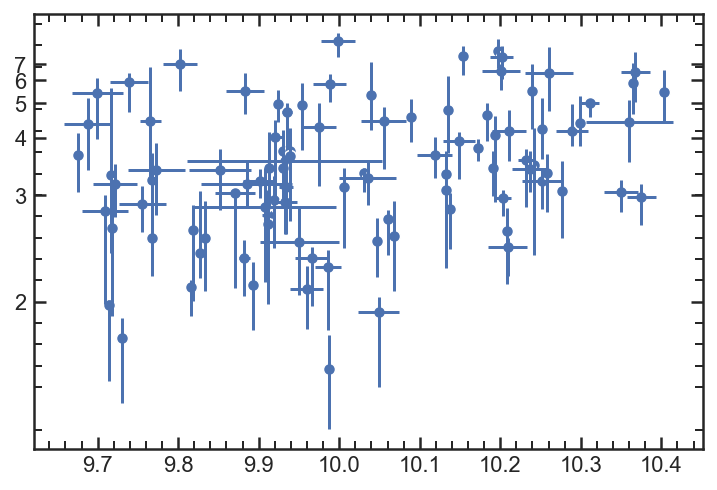

In [114]:
z50lerr = []
z50herr = []

for i in mdb.index:
    z50lerr.append(cosmo.lookback_time(mdb.z_50[i]).value - cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
    z50herr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value - cosmo.lookback_time(mdb.z_50[i]).value)

sea.scatterplot(lS1, cosmo.lookback_time(mdb.z_50.values).value)
plt.errorbar(lS1, cosmo.lookback_time(mdb.z_50.values).value, xerr = dlS1, yerr = [z50lerr, z50herr], linestyle = 'none')

plt.yticks(cosmo.lookback_time([2,3,4,5,6,7]).value,[2,3,4,5,6,7])


In [115]:
R=[]
dR = []
for i in mdb.index:
    r, dr = goodss_125.query('NUMBER == {0}'.format(mdb.id[i]))[['re','dre']].values[0]
    R.append(r)
    dR.append(dr)
    

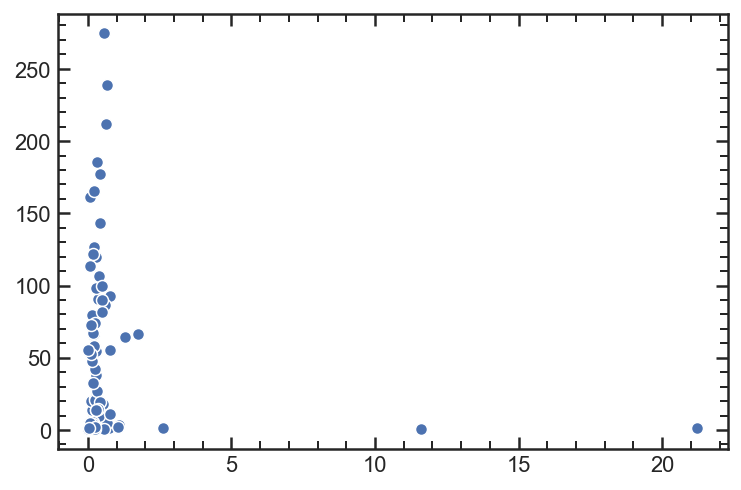

In [118]:
sea.scatterplot(R,np.array(R)/np.array(dR))

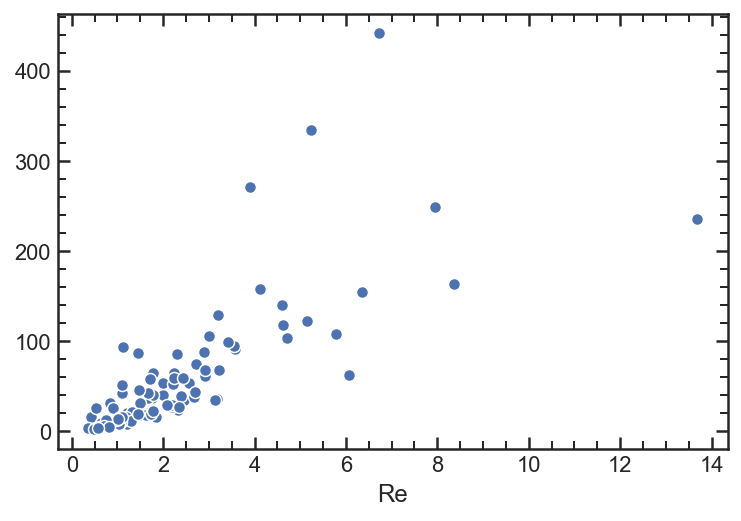

In [119]:
sea.scatterplot(mdb.Re,mdb.Re/mdb.Re_sig)